# Convolutional Generative Network for MNIST digits

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
import time

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)

!nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda
Tue Feb  6 13:59:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------

## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [ ]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 157590008.58it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24077856.06it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33062231.19it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21526021.21it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



**QUESTION:** Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


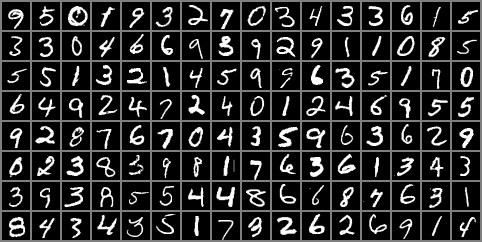

In [ ]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture guidelines for stable DCGANs mentioned in the [paper](https://arxiv.org/pdf/1511.06434.pdf) are:
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator). See this [github site](https://github.com/vdumoulin/conv_arithmetic) to view animations of all kind of convolutions.
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

**The generator** maps $z$ (a latent space vector sampled from a standard normal distribution) to data-space (in our case images the MNIST images having size 1x28x28).

In practice, this is accomplished through a series of Conv2DTranspose (Upsampling) layers each paired with a 2D batch norm layer and a Relu activation. We upsample the image three times so as to reach the desired image size. The output of the generator is fed through a tanh function to return it to the input data range of [-1,1].

**The discriminator** outputs the probability that the input (an image) came from real MNIST images rather than the generator.

In practice, this is accomplished through a series of Conv2d, 2D batch norm, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function.

In [ ]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
import torchsummary

# Create some generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)
torchsummary.summary(G, input_size=(nz,1,1))
torchsummary.summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]              64
             Tanh-14            [-1, 1,

## Display Samples of the Generator

Downloading: "https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt" to /root/.cache/torch/hub/checkpoints/wgan_epoch100.pt


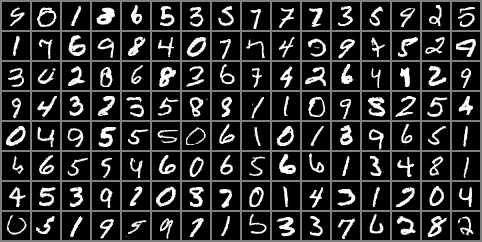

In [ ]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

# Load a pre-learned generator to see what you will get at the end of the practical session!:
G = Generator().to(device)
G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))

# Display samples
show(G)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

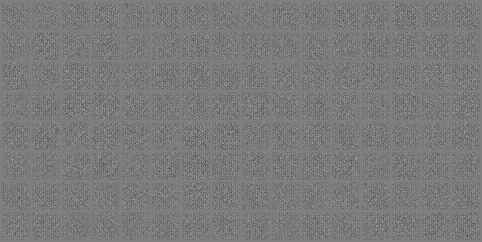

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G_fake = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G_fake.apply(weights_init);
D.apply(weights_init);

show(G_fake);

<br/><br/><br/><br/><br/>

# Exercise 1: DCGAN Training with WGAN-GP loss

<br/><br/>


**QUESTION:** Implement functions to estimate the Lipschitz constant and Gradient Penalty of the discriminator, and test them.
Conversely to TP2, $x$ and $y$ are here images and not point. So the interpolation concerns all the elements of the image i.e
$$
Z_{i,j}^k = \alpha X_{i,j}^k + (1 - \alpha)Y_{i,j}^k
$$
where $k \in \{1, \cdots, \text{batch_size}\}$, $i,j \in \{1, \cdots, 28\}$. The MNIST are of size 28 x 28 pixels.

In [ ]:
def product(x,y,alpha):
  interp = torch.empty((batch_size, 1, 28, 28), device = device)
  for k in range(batch_size):
      interp[k,0,:,:] = alpha[k]*x[k,0,:,:] + (1 - alpha[k])*y[k,0,:,:]
  return interp

In [ ]:
def lipconstant(D,x,y):
    # Calculate interpolation
    alpha = torch.rand(batch_size,device=device)
    interp = product(x,y,alpha)
    interp.requires_grad_()
    # Calculate discriminator on interpolated examples
    Di = D(interp)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size(), device = device)
    gradients = torch.autograd.grad(outputs = Di, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0]
    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim = 1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand(batch_size,device=device)
    interp = product(x,y,alpha)
    interp.requires_grad_()
    D_interp = D(interp)

    gradout = torch.ones(D_interp.size(), device = device)
    gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0]
    gradient_norm = torch.empty((gradients.size()[0]))
    for i in range(len(gradients)):
      gradient_norm[i] = (torch.norm(gradients[i]) - 1)**2
    # Return gradient penalty
    return torch.mean(gradient_norm)

# draw a batch of real samples
z = torch.randn(batch_size,nz,1,1).to(device)
y = G(z) #Real image
# draw a batch of fake samples
z = torch.randn(batch_size,nz,1,1).to(device)
x =  G_fake(z) #fake image

t1 = time.time()
print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))
t2 = time.time()
print(t2 - t1)

tensor(0.0505, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.5412, grad_fn=<MeanBackward0>)
0.7867729663848877


**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

[1/5][0/468][0.4676 s]	Loss_D: -0.1883	Loss_G: 0.3739	Lip(D): 0.0555


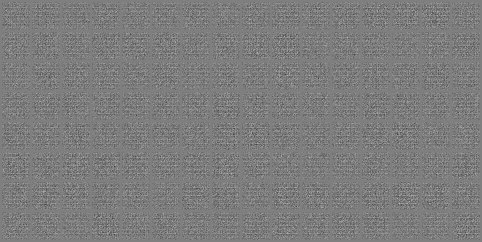

[1/5][100/468][15.7988 s]	Loss_D: -8.1573	Loss_G: 3.4221	Lip(D): 0.0984


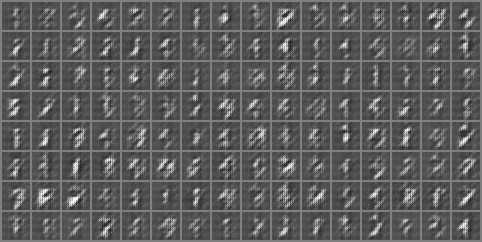

[1/5][200/468][30.7193 s]	Loss_D: -46.2035	Loss_G: 30.7847	Lip(D): 0.1711


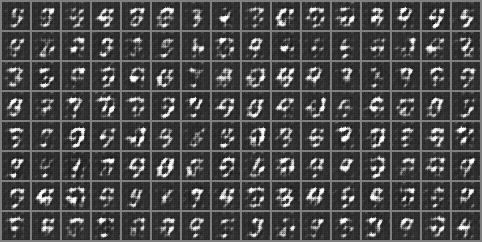

[1/5][300/468][45.6108 s]	Loss_D: -59.0795	Loss_G: 52.8452	Lip(D): 0.1844


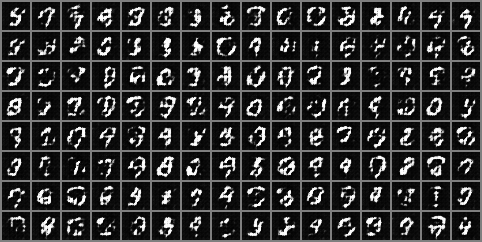

[1/5][400/468][60.6513 s]	Loss_D: -78.7917	Loss_G: 48.1321	Lip(D): 0.1423


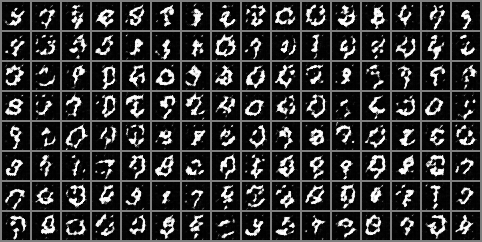

[2/5][0/468][71.0424 s]	Loss_D: -52.7569	Loss_G: 30.8214	Lip(D): 0.2315


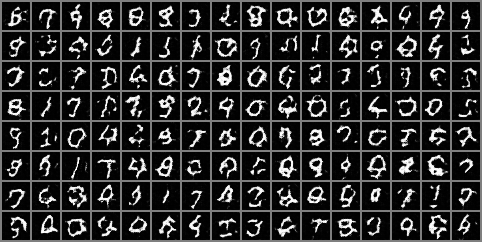

[2/5][100/468][86.4579 s]	Loss_D: -51.6617	Loss_G: 99.3277	Lip(D): 0.1452


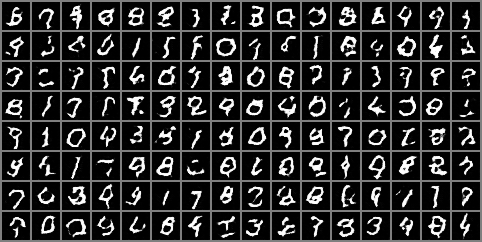

[2/5][200/468][101.3864 s]	Loss_D: -47.1693	Loss_G: 100.2937	Lip(D): 0.1168


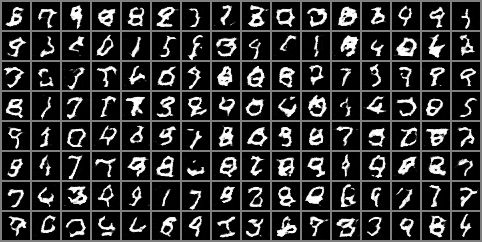

[2/5][300/468][116.5088 s]	Loss_D: -29.9605	Loss_G: 29.8156	Lip(D): 0.1592


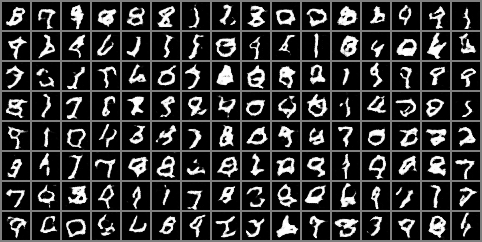

[2/5][400/468][131.5698 s]	Loss_D: -10.7450	Loss_G: 3.9131	Lip(D): 0.2012


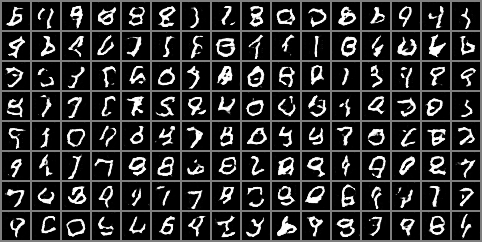

[3/5][0/468][142.2859 s]	Loss_D: -73.6852	Loss_G: 83.1006	Lip(D): 0.1729


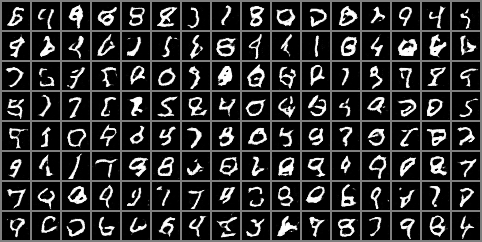

[3/5][100/468][157.6294 s]	Loss_D: -31.5969	Loss_G: 93.0295	Lip(D): 0.1507


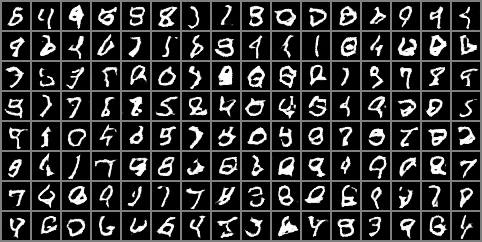

[3/5][200/468][173.0022 s]	Loss_D: -47.8051	Loss_G: 106.2799	Lip(D): 0.1502


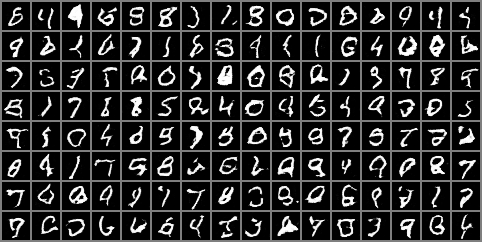

[3/5][300/468][187.9847 s]	Loss_D: -27.5427	Loss_G: 84.3613	Lip(D): 0.1897


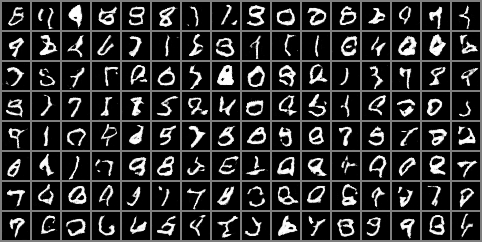

[3/5][400/468][202.8162 s]	Loss_D: -23.2583	Loss_G: 170.4915	Lip(D): 0.1269


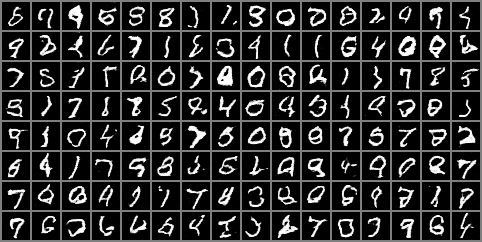

[4/5][0/468][213.4291 s]	Loss_D: 13.7387	Loss_G: -25.3521	Lip(D): 0.2078


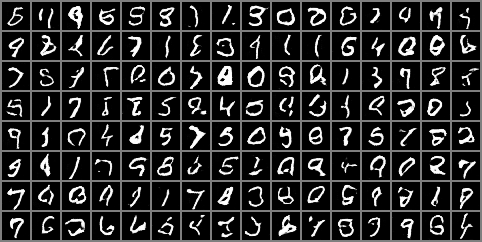

[4/5][100/468][228.5397 s]	Loss_D: 4.8306	Loss_G: 61.3787	Lip(D): 0.2355


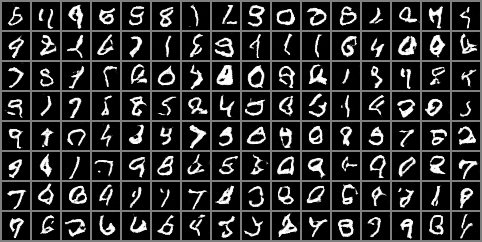

[4/5][200/468][243.9545 s]	Loss_D: -2.5410	Loss_G: 101.7569	Lip(D): 0.2379


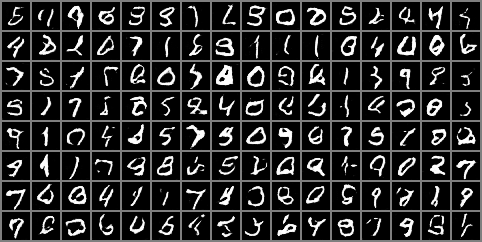

[4/5][300/468][258.8347 s]	Loss_D: -30.0602	Loss_G: 107.0176	Lip(D): 0.1914


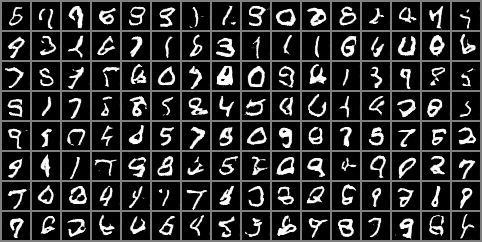

[4/5][400/468][273.7389 s]	Loss_D: -62.8937	Loss_G: 89.5630	Lip(D): 0.1965


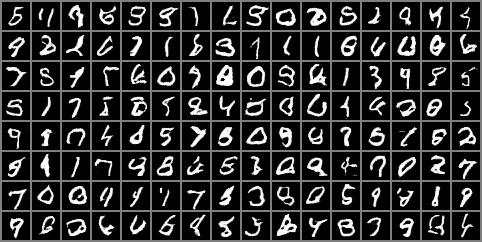

[5/5][0/468][284.2539 s]	Loss_D: -11.8328	Loss_G: 212.0831	Lip(D): 0.2153


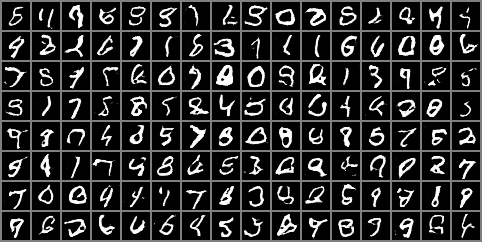

[5/5][100/468][299.1834 s]	Loss_D: -41.2796	Loss_G: 97.1701	Lip(D): 0.2106


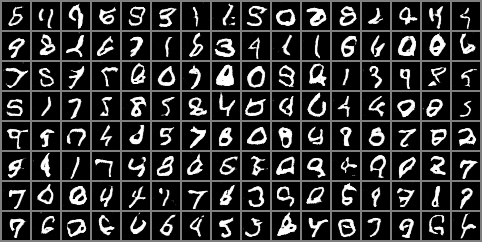

[5/5][200/468][314.3705 s]	Loss_D: -18.6065	Loss_G: 156.2910	Lip(D): 0.1967


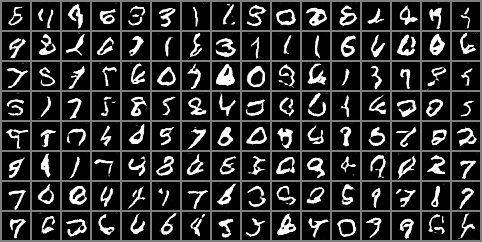

[5/5][300/468][329.8685 s]	Loss_D: -23.6267	Loss_G: 163.9074	Lip(D): 0.2420


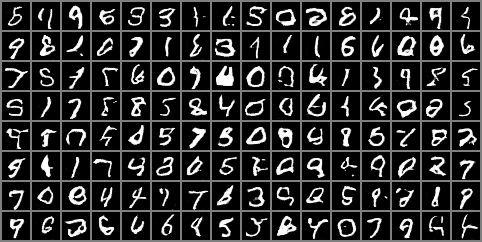

[5/5][400/468][345.2808 s]	Loss_D: -32.2295	Loss_G: 118.3567	Lip(D): 0.1984


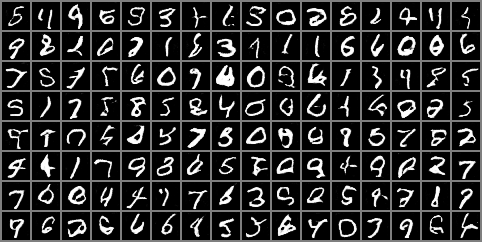

Total learning time =  355.45017671585083


In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G_fake = Generator().to(device)
D = Discriminator().to(device)
G_fake.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G_fake.parameters(), lr=0.0002, betas=(0.5, 0.999)) #Attention, mettre le bon générateur G_fake et non G

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()

for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):
        ############################
        # Draw Batches of real and fake images
        x,_ = batch
        x = x.cuda() #Convert it for  GPU

        z = torch.randn(batch_size,nz,1,1).to(device)
        x_fake =  G_fake(z) #Fake images

        ############################
        # Update D network : It has to discriminate between x_fake and x

        optimD.zero_grad()
        Dx = D(x_fake.detach())
        Dy = D(x) #Known
        Dloss = -(torch.mean(Dy) - torch.mean(Dx) - gpw*gradient_penalty(D,x_fake,x))
        Dloss.backward(retain_graph = True)
        optimD.step()

        ############################
        # Update G network

        optimG.zero_grad()
        z = torch.randn(batch_size,nz,1,1).to(device)
        Dx = D(G_fake(z))
        Gloss = -torch.mean(Dx)
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,x_fake,x)))
            show(G_fake,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())

# Save final generator in a file
torch.save(G.state_dict(), 'wgan.pt')

# Exercise 2: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

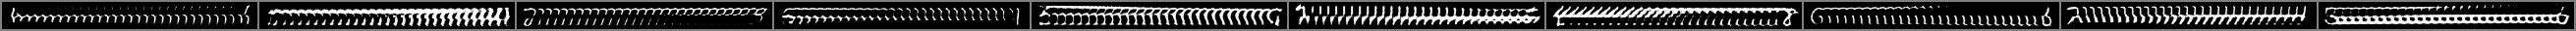

In [ ]:
# # Uncomment the following lines if you want to load a pretrained generator:
G = Generator().to(device)
G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))


G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10    # number of latent variables
nk = 30       # number of alpha values

z0 = torch.randn(minib,nz,1,1).to(device)
z1 = torch.randn(minib,nz,1,1).to(device)

alpha = torch.tensor(np.linspace(0,1,nk)).to(device)

z = alpha*z0 + (1 - alpha)*z1
z = z.float()

genimages = G_fake(z)

pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset


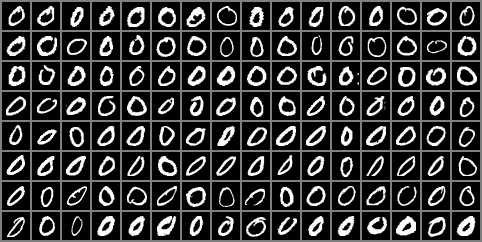

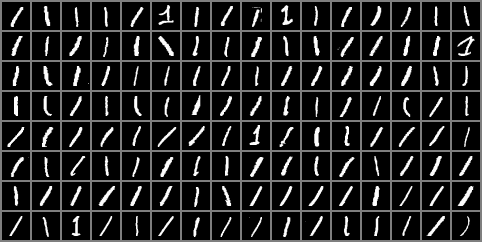

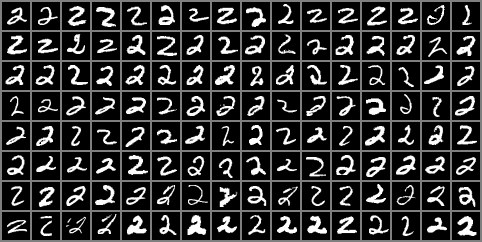

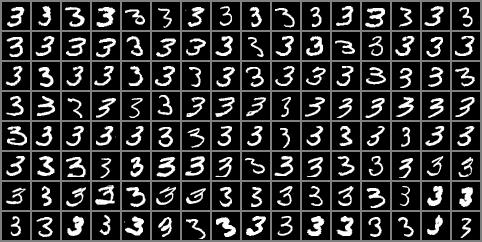

In [ ]:
# extract all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

# For fun, display parts of the database corresponding to different figures
realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

Don't understand what I am supposed to do

In [ ]:

x = G(z0)    # minib samples of the generative model

### ... ###

xnn =    # nearest neighbors in the dataset

im = torch.zeros((minib*2,1,28,28)).to(device)
im[0:minib,:,:,:] = x
im[minib:2*minib,:,:,:] = xnn

imshow(torchvision.utils.make_grid(im.to('cpu'),nrow=10),size=200)

## Quantitative Evaluation of the Generative Model

**QUESTION:** How to evaluate the quality of the resulting generative model? Are "Inception Score" or "Fréchet Inception Distance" appropriate?

In [ ]:
# See https://stackoverflow.com/questions/57183647/frechet-inception-distance-for-dc-gan-trained-on-mnist-dataset
# ...
# If you want to know more about FID, I recommend you looking at the following implementation:
#   https://github.com/mseitzer/pytorch-fid
# If you just want to load the inception_v3 network on which FID is based, you can run
#model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).to(device)
# model.eval()
#
# Alternately, you can compute an adapted FID by using a network trained to classify MNIST data.

<br/><br/><br/><br/><br/>

# Exercise 3: DCGAN Training with GAN loss

<br/><br/>
**QUESTION:** Implement GAN training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the (opposite of the) loss to minimize for the discriminator using `nn.BCEWithLogitsLoss` <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the loss to minimize using `nn.BCEWithLogitsLoss`  
> > Compute the gradient and do an optimizer step for the generator parameters

[1/5][0/468][0.3275 s]	Loss_D: -0.7560	Loss_G: -0.0797	Lip(D): 0.0538


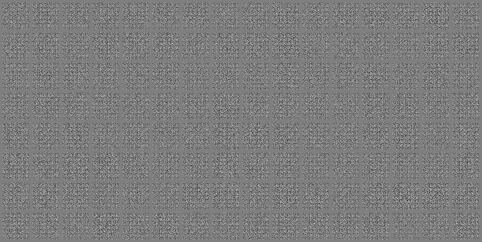

[1/5][100/468][11.2098 s]	Loss_D: -1.9354	Loss_G: 8.8790	Lip(D): 0.0667


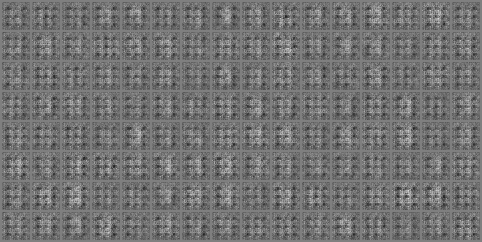

[1/5][200/468][22.0735 s]	Loss_D: 3.3511	Loss_G: 0.9931	Lip(D): 0.0803


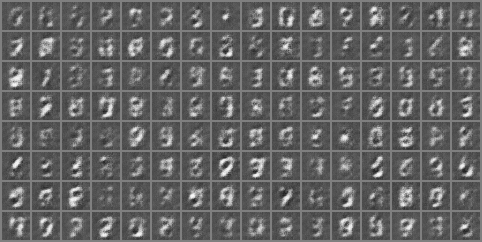

[1/5][300/468][32.8577 s]	Loss_D: 6.4889	Loss_G: 26.5874	Lip(D): 0.1174


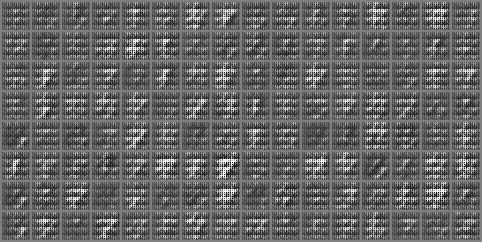

[1/5][400/468][43.8685 s]	Loss_D: 0.8994	Loss_G: -11.4565	Lip(D): 0.2426


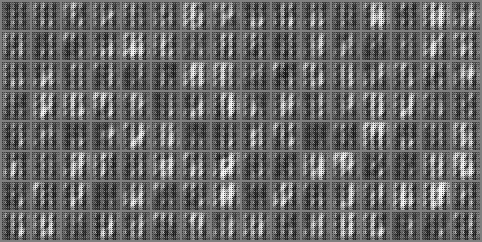

[2/5][0/468][51.8187 s]	Loss_D: -19.8952	Loss_G: 13.6268	Lip(D): 0.2021


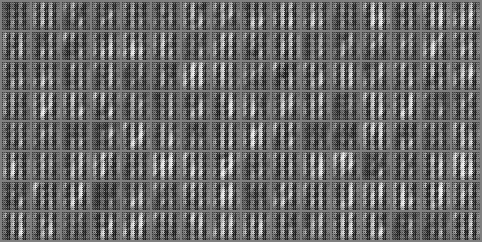

[2/5][100/468][62.6855 s]	Loss_D: -0.7207	Loss_G: 54.9902	Lip(D): 0.1486


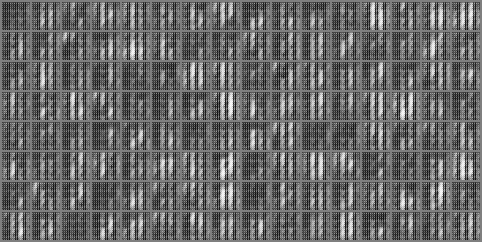

[2/5][200/468][73.5208 s]	Loss_D: -15.0509	Loss_G: 47.8040	Lip(D): 0.1604


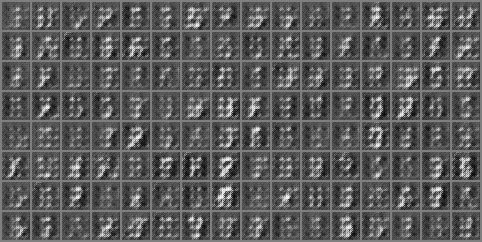

[2/5][300/468][84.4136 s]	Loss_D: 0.0235	Loss_G: 4.7238	Lip(D): 0.1523


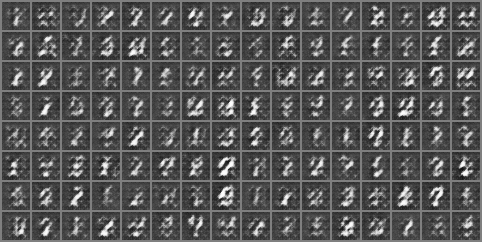

[2/5][400/468][94.9112 s]	Loss_D: -9.0264	Loss_G: 48.5571	Lip(D): 0.1755


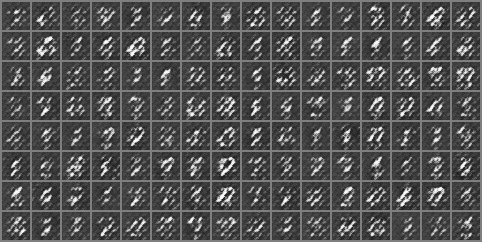

[3/5][0/468][102.7861 s]	Loss_D: -10.5679	Loss_G: 5.1860	Lip(D): 0.2293


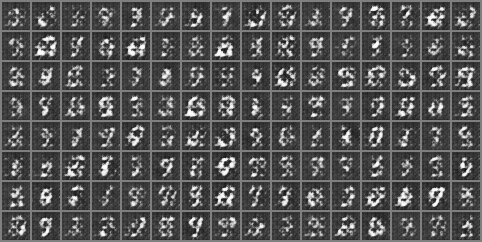

[3/5][100/468][113.7968 s]	Loss_D: -41.5172	Loss_G: 82.2627	Lip(D): 0.1976


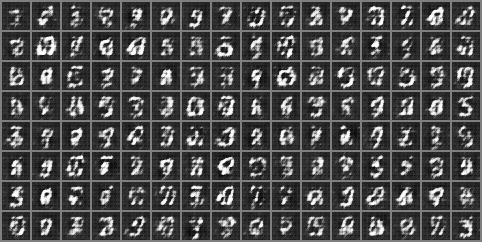

[3/5][200/468][124.8170 s]	Loss_D: 1.9640	Loss_G: 62.1616	Lip(D): 0.2574


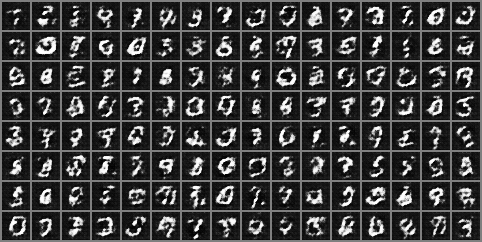

[3/5][300/468][135.7185 s]	Loss_D: 1.6710	Loss_G: 12.4784	Lip(D): 0.2230


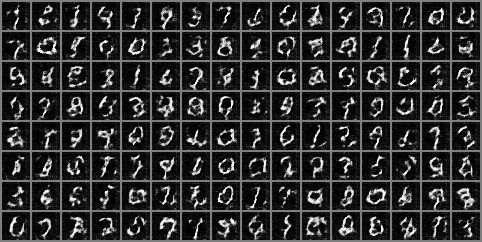

[3/5][400/468][146.6571 s]	Loss_D: -43.1325	Loss_G: 32.7273	Lip(D): 0.2322


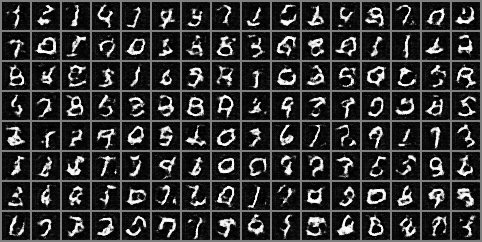

[4/5][0/468][154.0776 s]	Loss_D: -28.3907	Loss_G: 20.2757	Lip(D): 0.1914


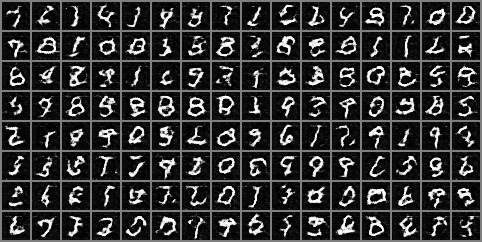

[4/5][100/468][165.1008 s]	Loss_D: -6.0183	Loss_G: -0.9326	Lip(D): 0.2060


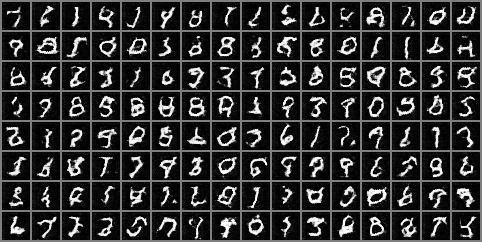

[4/5][200/468][176.1421 s]	Loss_D: -18.7172	Loss_G: 26.7698	Lip(D): 0.2107


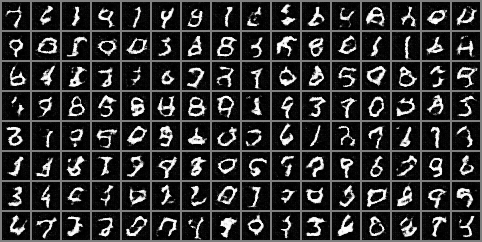

[4/5][300/468][187.1461 s]	Loss_D: -0.1458	Loss_G: 5.2214	Lip(D): 0.1986


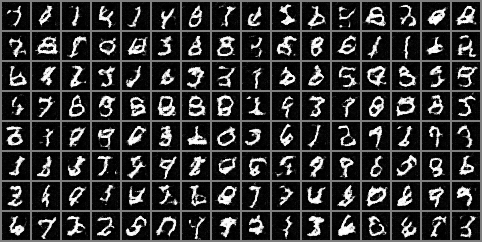

[4/5][400/468][198.1606 s]	Loss_D: -3.1521	Loss_G: 4.2054	Lip(D): 0.2243


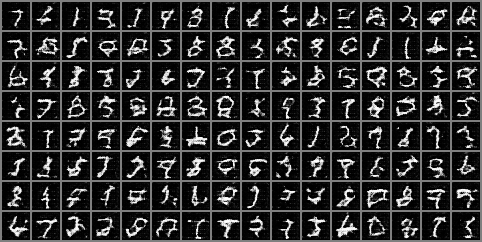

[5/5][0/468][206.1750 s]	Loss_D: 9.8800	Loss_G: 14.1014	Lip(D): 0.2524


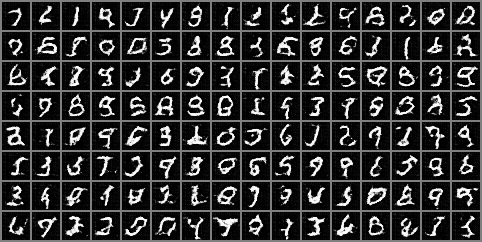

[5/5][100/468][216.9706 s]	Loss_D: -11.3862	Loss_G: 14.2755	Lip(D): 0.2521


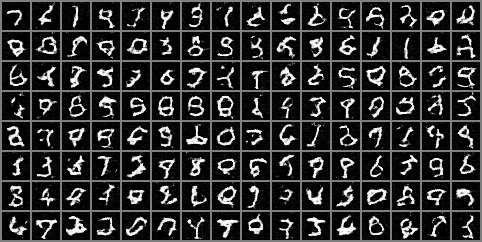

[5/5][200/468][228.0654 s]	Loss_D: 16.8526	Loss_G: 44.6774	Lip(D): 0.2347


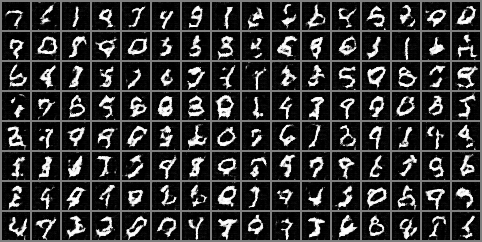

[5/5][300/468][239.1139 s]	Loss_D: -12.9645	Loss_G: 20.9158	Lip(D): 0.2432


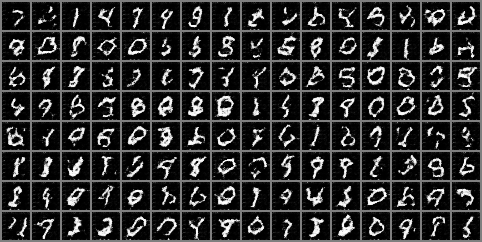

[5/5][400/468][250.0899 s]	Loss_D: 19.6649	Loss_G: 10.2957	Lip(D): 0.2208


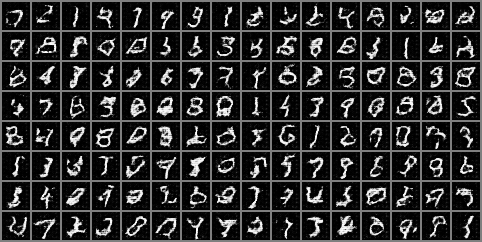

Total learning time =  257.9062075614929


In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility
torch.autograd.set_detect_anomaly(True)

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999)) #Attention, mettre le bon générateur G_fake et non G

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()


for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):
        ############################
        # Draw Batches of real and fake images
        x,_ = batch
        x = x.cuda() #Convert it for  GPU

        z = torch.randn(batch_size,nz,1,1).to(device)
        x_fake =  G(z) #Fake images

        pos_weight = torch.ones(batch_size).to(device)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)

        ############################
        # Update D network : It has to discriminate between x_fake and x

        optimD.zero_grad()
        Dx = D(x_fake.detach())
        Dy = D(x) #Known
        Dloss = -criterion(Dx,Dy)
        Dloss.backward(retain_graph = True)
        optimD.step()

        ############################
        # Update G network

        optimG.zero_grad()
        z1 = torch.randn(batch_size,nz,1,1).to(device)
        Dx1 = D(G(z1))
        Dy1 = D(x.detach())
        Gloss = criterion(Dx1,Dy1)
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,x_fake,x)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())

# Save final generator in a file
torch.save(G.state_dict(), 'wgan.pt')